# Tuning Confidence Score of Flight Call Detections
_Ashley Huang, Carlene English_

In [28]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from scipy.stats import gaussian_kde
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timezone, timedelta
from suntime import Sun
from dateutil import tz

In [29]:
taxon = 'uplsan'

common_names = {
    'semplo': 'Semipalmated Plover', 
    'greyel': 'Greater Yellowlegs', 
    'lobcur': 'Long-billed Curlew', 
    'uplsan': 'Upland Sandpiper', 
    'baisan': 'Baird\'s Sandpiper', 
    'wilsni': 'Wilson\'s Snipe', 
    'leasan': 'Least Sandpiper'
}

## 1. Plot the distribution of confidence scores
The `reviewStutus` column of the exported CSV file can be either `Reviewed`, `Problem`, or `Unreviewed`. In this notebook, we will use _correct_ and _incorrect_ to describe `Reviewed` and `Problem` detections; the term _reviewed_ will denote both _correct_ and _incorrect_ detections.
We plot histograms of the confidence scores of `Reviewed`, 

   recordingId                            assetName  \
0       957294   FLOOD_2018-10-07_18.34.00_Z_29.wav   
1       872672   FLOOD_2018-08-22_20.04.00_Z_60.wav   
2       872672   FLOOD_2018-08-22_20.04.00_Z_60.wav   
3       872672   FLOOD_2018-08-22_20.04.00_Z_60.wav   
4       872564  FLOOD_2018-08-21_20.06.00_Z_166.wav   

               originalAssetName  originalAssetStartSec  duration   site  \
0  FLOOD-21C_20181007_183400.wav                48239.5       4.2  FLOOD   
1  FLOOD-21C_20180822_200400.wav                35929.7       8.8  FLOOD   
2  FLOOD-21C_20180822_200400.wav                35929.7       8.8  FLOOD   
3  FLOOD-21C_20180822_200400.wav                35929.7       8.8  FLOOD   
4  FLOOD-21C_20180821_200600.wav                29099.7       4.6  FLOOD   

      season                 timestamp  datasets  annotationId  ... startSec  \
0  Fall 2024  2018-10-08T07:57:59.501Z       NaN       1736960  ...      1.5   
1  Fall 2024  2018-08-23T06:02:49.701Z       NaN    

reviewStatus
Unreviewed    2788
Problem        413
Reviewed       192
Name: count, dtype: int64

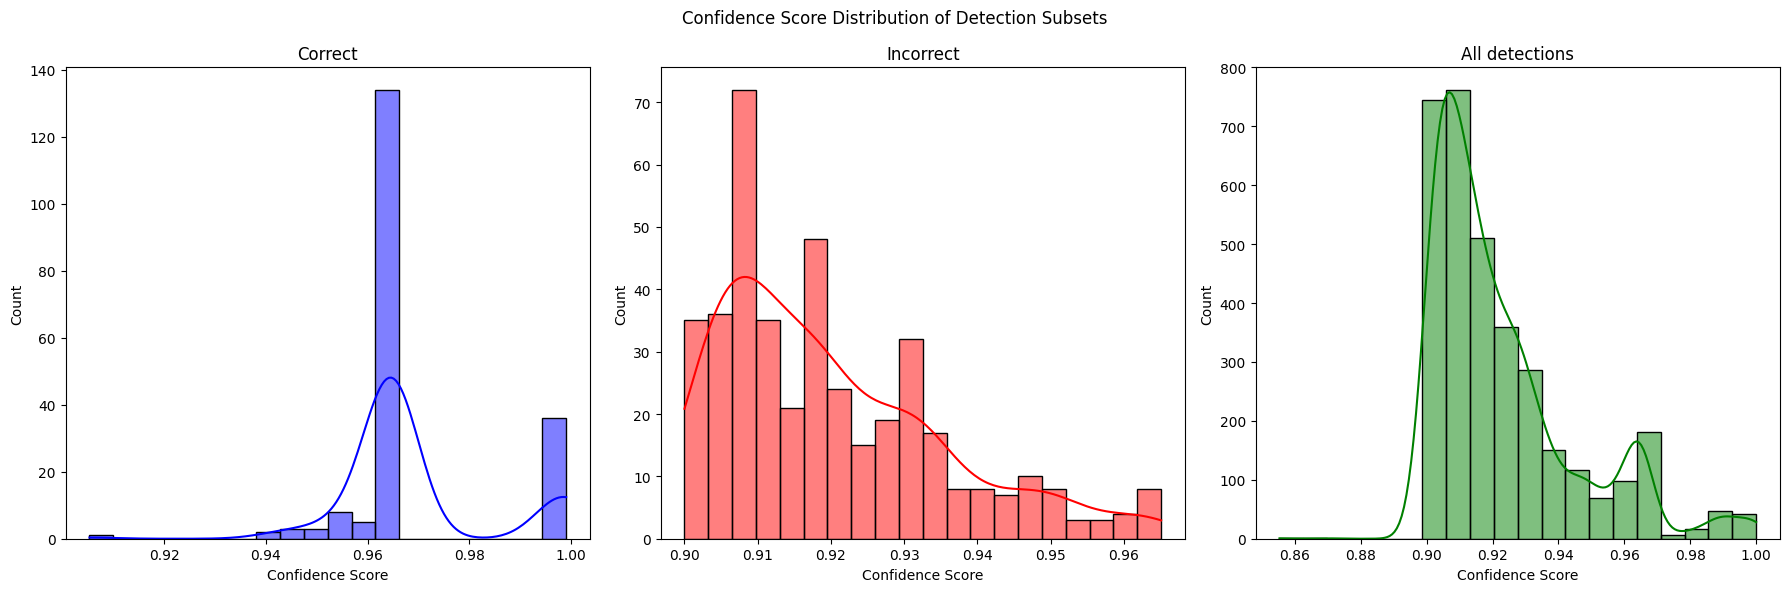

In [30]:
if taxon == 'uplsan':
    df_flood = pd.read_csv(f'detections/uplsan_flood.csv')
    df_correct = pd.read_csv(f'detections/uplsan_correct.csv')
    df_incorrect = pd.read_csv(f'detections/uplsan_incorrect.csv')
    df = pd.concat([df_flood, df_correct, df_incorrect])
    print(df.head())
else:
    df = pd.read_csv(f'detections/{taxon}.csv')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.histplot(df[df['reviewStatus'] == 'Reviewed']['confidenceScore'].values, bins=20, kde=True, color='b', ax=axes[0])
sns.histplot(df[df['reviewStatus'] == 'Problem']['confidenceScore'].values, bins=20, kde=True, color='r', ax=axes[1])
sns.histplot(df['confidenceScore'].values, bins=20, kde=True, color='g', ax=axes[2])
axes[0].set_title('Correct')
axes[1].set_title('Incorrect')
axes[2].set_title('All detections')
axes[0].set_xlabel('Confidence Score')
axes[1].set_xlabel('Confidence Score')
axes[2].set_xlabel('Confidence Score')
plt.suptitle('Confidence Score Distribution of Detection Subsets')
plt.tight_layout()

df['reviewStatus'].value_counts()

## Apply Filters
First, we filter out unreviewed detections and assign 0/1 to incorrect/correct detections. Then, we filter out daytime flight calls. Timestamps are compared to the sunset/sunrise time of MPG ranch. Once we obtained coordinated of each site, timestamp should be compared to the sunset/sunrise time of the corresponding site.

In [31]:
# Filter out unreviewed detections
df['reviewStatusBinary'] = df['reviewStatus'].map({'Reviewed': 1, 'Problem': 0, 'Unreviewed': -1})
df_reviewed = df[df['reviewStatusBinary'] >= 0]

# Filter by sunset and sunrise time
time_format = '%Y-%m-%dT%H:%M:%S.%fZ'
lat, lon = 47.0559593, -116.3273099
sun = Sun(lat, lon)
def is_noctural(time_str, after_sunset=timedelta(minutes=0), before_sunrise=timedelta(minutes=0)):
    timestamp = datetime.strptime(time_str, time_format)
    timestamp = timestamp.replace(tzinfo=timezone.utc)
    sunrise = sun.get_local_sunrise_time(timestamp, tz.gettz('America/Denver'))
    sunset = sun.get_local_sunset_time(timestamp + timedelta(days=1), tz.gettz('America/Denver'))
    timestamp.astimezone(tz.gettz('American/Denver'))
    if timestamp.date() != sunset.date() or timestamp.date() != sunrise.date():
        print(sunrise, sunset, timestamp)
    if timestamp < sunrise - before_sunrise or timestamp > sunset + after_sunset:
        return True
    return False
total_detections = len(df_reviewed.index)
df_reviewed = df_reviewed[df_reviewed['timestamp'].apply(is_noctural)]
print('nocturnal detections:', total_detections)
print('durinal detections:', total_detections - len(df_reviewed.index))

scores = df['confidenceScore']
scores_reviewed = df_reviewed['confidenceScore']

kde = gaussian_kde(scores)
kde_reviewed = gaussian_kde(scores_reviewed)
weights = kde.evaluate(scores_reviewed) / kde_reviewed.evaluate(scores_reviewed)
weights /= weights.sum()



nocturnal detections: 605
durinal detections: 120


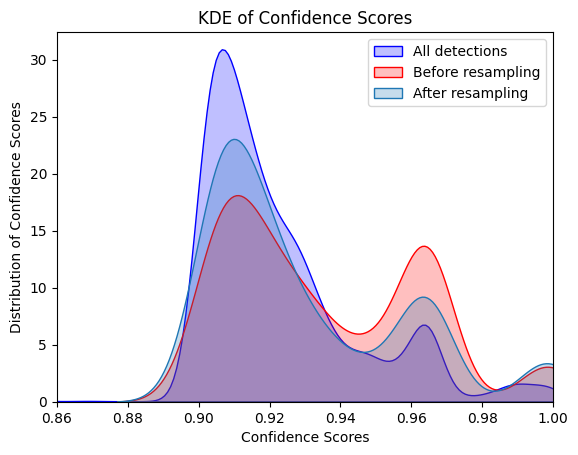

In [36]:
indicies = np.random.choice(df_reviewed.index, size=len(df_reviewed), p=weights, replace=True)
df_resampled = df_reviewed.loc[indicies]

X = df_resampled['confidenceScore'].values.reshape(-1, 1) # X.shape = (N, 1)
y = df_resampled['reviewStatusBinary'].values # y.shape = (N)

sns.kdeplot(scores, fill=True, color='blue', label='All detections')
sns.kdeplot(df[df['reviewStatus'].isin(['Reviewed', 'Problem'])]['confidenceScore'].values, fill=True, color='red', label='Before resampling')
sns.kdeplot(X, fill=True, color='green', label='After resampling')
plt.title('KDE of Confidence Scores')
plt.xlabel('Confidence Scores')
plt.ylabel('Distribution of Confidence Scores')
plt.xlim(df['confidenceScore'].quantile(1e-4), 1)
plt.legend()

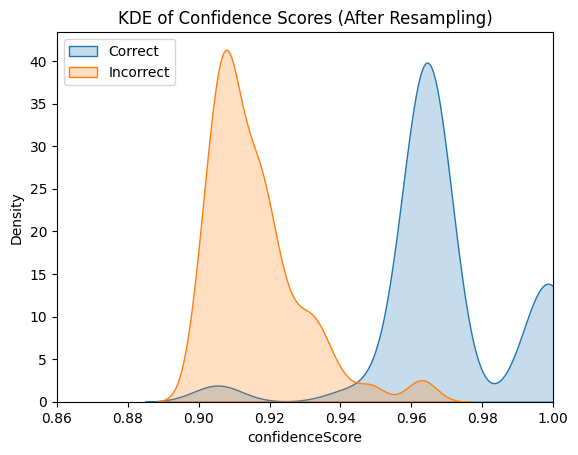

In [33]:
sns.kdeplot(data=df_resampled[df_resampled['reviewStatusBinary'] == 1], x='confidenceScore', label='Correct', fill=True)
sns.kdeplot(data=df_resampled[df_resampled['reviewStatusBinary'] == 0], x='confidenceScore', label='Incorrect', fill=True)
plt.title('KDE of Confidence Scores (After Resampling)')
plt.xlim(df['confidenceScore'].quantile(1e-4), 1)
plt.legend()

(0.8599604454040529, 1.0)

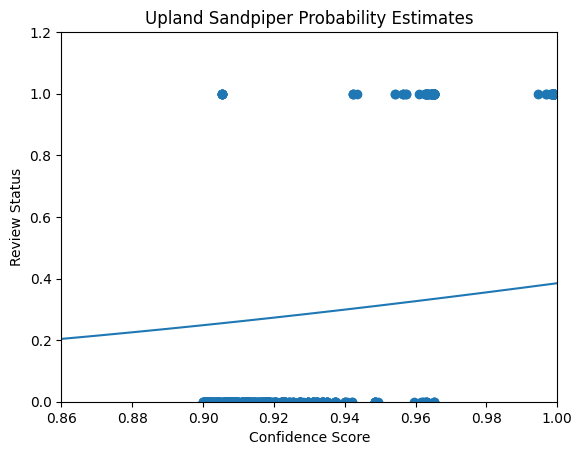

In [35]:
logr = LogisticRegression()
logr.fit(X, y)

plt.scatter(df_resampled['confidenceScore'], df_resampled['reviewStatusBinary'])
plt.ylim(0, 1.2)
plt.xlabel('Confidence Score')
plt.ylabel('Review Status')
plt.title(f'{common_names[taxon]} Probability Estimates')

x_range = np.linspace(0, 1, 100).reshape(-1, 1)
y_prob = logr.predict_proba(x_range)[:, 1]
plt.plot(x_range, y_prob)
plt.xlim(df['confidenceScore'].quantile(1e-4), 1)